# Analyzer

Statistically, visually, and through machine learning compare mRNA and lncRNA sequences from GENCODE v38.

Assume the user downloaded files from GENCODE v38 [FTP](http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/)
to a subdirectory called data.

## Import Dependencies


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import gzip
from scipy.stats import chisquare, kstest
import sys

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
      f.write(s.text)  # writes to cloud local, delete the file later?
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open ('GenCodeTools.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/plot_generator.py')
    with open('plot_generator.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
      f.write(s.text)  
    from KmerTools import KmerTools
    from RNA_describe import *
    from GenCodeTools import *
    from plot_generator import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='../data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_describe import *
    from SimTools.GenCodeTools import *
    from SimTools.plot_generator import *
    from SimTools.KmerTools import KmerTools

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_describe():
    print("ERROR: Cannot use RNA_describe.")

On Google CoLab, mount cloud-local file, get our code from GitHub.
Mounted at /content/drive/


## Load GENCODE Data
Loads GENCODE v38 data.

Filters out mRNA sequences based on UTR check.

In [ ]:
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_list(None) 
loader.set_check_utr(True)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_list(None)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))

PC seqs loaded: 70825
NC seqs loaded: 48752


## Process Sequences


Generate Sample of GENCODE Data Set

Apply Length Constraints

Validate Sequences

In [ ]:
APPLY_SUBSET = True             #Option to subset the data
MINIMUM_SEQUENCE_LENGTH = 200   #Minimum exclusive length to filter out sequences by
MAXIMUM_SEQUENCE_LENGTH = 4000  #Maximum inclusive length to filter out sequences by
SAMPLE_FRACTION = 1             #What fraction of the GenCode data set to take a sample of
REPRODUCABILITY_SEED = 314159   #Use to reproduce random sampling

In [ ]:
if APPLY_SUBSET:
    pcdf = pcdf.sample(frac=SAMPLE_FRACTION, random_state=REPRODUCABILITY_SEED)
    ncdf = ncdf.sample(frac=SAMPLE_FRACTION, random_state=REPRODUCABILITY_SEED)

    print('PC sample size:', len(pcdf))
    print('NC sample size:', len(ncdf))

PC sample size: 70825
NC sample size: 48752


Apply Length Constraints

In [ ]:
def subset_list_by_len_bounds(input_list, min_len, max_len):
  return list(filter(lambda x: len(x) > min_len and len(x) <= max_len, input_list))

In [ ]:
pc_sequences = pcdf['sequence'].tolist()
nc_sequences = ncdf['sequence'].tolist()

if APPLY_SUBSET:
    pc_sequences = subset_list_by_len_bounds(pc_sequences, MINIMUM_SEQUENCE_LENGTH, MAXIMUM_SEQUENCE_LENGTH)
    nc_sequences = subset_list_by_len_bounds(nc_sequences, MINIMUM_SEQUENCE_LENGTH, MAXIMUM_SEQUENCE_LENGTH)

    print('PC seqs in length range','('+str(MINIMUM_SEQUENCE_LENGTH),'-',str(MAXIMUM_SEQUENCE_LENGTH)+'):', len(pc_sequences))
    print('NC seqs in length range','('+str(MINIMUM_SEQUENCE_LENGTH),'-',str(MAXIMUM_SEQUENCE_LENGTH)+'):', len(nc_sequences))

#Garbage collection
pcdf = None
ncdf = None

PC seqs in length range (200 - 4000): 55381
NC seqs in length range (200 - 4000): 46912


Validate Sequences

In [ ]:
def valid_sequence(seq):
    """
    Checks if the given sequences if valid.
    """
    for chr in seq:
        if not (chr == 'A' or chr == 'C' or chr == 'G' or chr == 'T'):
            return False
    return True

def validate_sequences(sequences):
    """
    Validate the given list of sequences
    """
    i = 0
    while i < len(sequences):
        if valid_sequence(sequences[i]):
            i += 1
        else:
            sequences.remove(sequences[i])

validate_sequences(pc_sequences)
validate_sequences(nc_sequences)

print('Valid PC seqs:', len(pc_sequences))
print('Valid NC seqs:', len(nc_sequences))

Valid PC seqs: 55381
Valid NC seqs: 46911


## Generate Simulated Sequences

In [ ]:
NUM_FAKE_SEQS_PER_LENGTH = 15
random.seed(REPRODUCABILITY_SEED)
fake_sequences = []
for length in range(MINIMUM_SEQUENCE_LENGTH + 1, MAXIMUM_SEQUENCE_LENGTH + 1):
    for size in range(0, NUM_FAKE_SEQS_PER_LENGTH):
        sequence = ''.join(random.choices(['A', 'C', 'G', 'T'], k=length))
    fake_sequences.append(sequence)

print('Simulated Sequences:', len(fake_sequences))

Simulated Sequences: 3800


## Generate Statistics


Using KmerTools to get the K-mer counts upto 3.
It returns the value in Dictionary form. (Key-Value Pair)

In [ ]:
MAX_K = 3
tool = KmerTools()

pc_counts = tool.make_dict_upto_K(MAX_K)
for sample in pc_sequences:
    tool.update_count_one_K(pc_counts,MAX_K,sample,True)
tool.harvest_counts_from_K(pc_counts,MAX_K)
pc_freqs = tool.count_to_frequency(pc_counts,MAX_K)

nc_counts = tool.make_dict_upto_K(MAX_K)
for sample in nc_sequences:
    tool.update_count_one_K(nc_counts,MAX_K,sample,True)
tool.harvest_counts_from_K(nc_counts,MAX_K)
nc_freqs = tool.count_to_frequency(nc_counts,MAX_K)

fake_counts = tool.make_dict_upto_K(MAX_K)
for sample in fake_sequences:
  tool.update_count_one_K(fake_counts, MAX_K, sample, True)
tool.harvest_counts_from_K(fake_counts, MAX_K)
fake_freqs = tool.count_to_frequency(fake_counts, MAX_K)

#Garbage collection
pc_counts = None
nc_counts = None
fake_counts = None

In [ ]:
ONE_MER_MIN = 0
ONE_MER_MAX = 4**1
TWO_MER_MIN = 4**1
TWO_MER_MAX = 4**2 + 4**1
THREE_MER_MIN = 4**2 + 4**1
THREE_MER_MAX = 4**3 + 4**2 + 4**1

one_mer_keys = list(pc_freqs.keys())[ONE_MER_MIN:ONE_MER_MAX]
two_mer_keys = list(pc_freqs.keys())[TWO_MER_MIN:TWO_MER_MAX]
three_mer_keys = list(pc_freqs.keys())[THREE_MER_MIN:THREE_MER_MAX]

pc_freqs = list(pc_freqs.values())
nc_freqs = list(nc_freqs.values())
fake_freqs = list(fake_freqs.values())

one_mer_pc = np.asarray(pc_freqs[ONE_MER_MIN:ONE_MER_MAX])
one_mer_nc = np.asarray(nc_freqs[ONE_MER_MIN:ONE_MER_MAX])
one_mer_fake = np.asarray(fake_freqs[ONE_MER_MIN:ONE_MER_MAX])

two_mer_pc = np.asarray(pc_freqs[TWO_MER_MIN:TWO_MER_MAX])
two_mer_nc = np.asarray(nc_freqs[TWO_MER_MIN:TWO_MER_MAX])
two_mer_fake = np.asarray(fake_freqs[TWO_MER_MIN:TWO_MER_MAX])

three_mer_pc = np.asarray(pc_freqs[THREE_MER_MIN:THREE_MER_MAX])
three_mer_nc = np.asarray(nc_freqs[THREE_MER_MIN:THREE_MER_MAX])
three_mer_fake = np.asarray(fake_freqs[THREE_MER_MIN:THREE_MER_MAX])

#Garbage collection
pc_freqs = None
nc_freqs = None
fake_freqs = None

Generate max ORF lengths

In [ ]:
oc = ORF_counter()

pc_max_orf_len = np.empty(1, dtype=object)
nc_max_orf_len = np.empty(1, dtype=object)
fake_max_orf_len = np.empty(1, dtype=object)

pc_max_orf_len[0] = np.zeros(len(pc_sequences))
nc_max_orf_len[0] = np.zeros(len(nc_sequences))
fake_max_orf_len[0] = np.zeros(len(fake_sequences))

for i in range(len(pc_sequences)):
    oc.set_sequence(pc_sequences[i])
    pc_max_orf_len[0][i] = oc.get_max_orf_len()
for i in range(len(nc_sequences)):
    oc.set_sequence(nc_sequences[i])
    nc_max_orf_len[0][i] = oc.get_max_orf_len()
for i in range(len(fake_sequences)):
    oc.set_sequence(fake_sequences[i])
    fake_max_orf_len[0][i] = oc.get_max_orf_len()

Get sequence lengths and sequence length vs. max ORF length correlation coefficients

In [ ]:
pc_seq_len = np.asarray(list(map(lambda x : len(x), pc_sequences)))
pc_seq_len_orf_len_corrcoef = np.corrcoef(pc_seq_len, pc_max_orf_len[0])
nc_seq_len = np.asarray(list(map(lambda x : len(x), nc_sequences)))
nc_seq_len_orf_len_corrcoef = np.corrcoef(nc_seq_len, nc_max_orf_len[0])
fake_seq_len = np.asarray(list(map(lambda x : len(x), fake_sequences)))
fake_seq_len_orf_len_corrcoef = np.corrcoef(fake_seq_len, fake_max_orf_len[0])

## Results

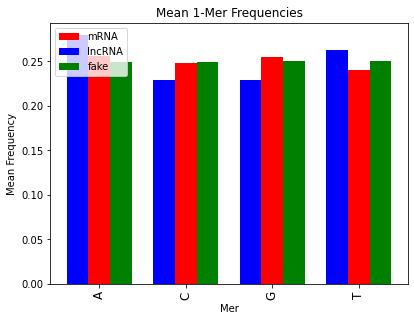

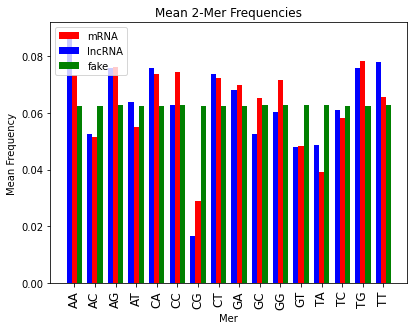

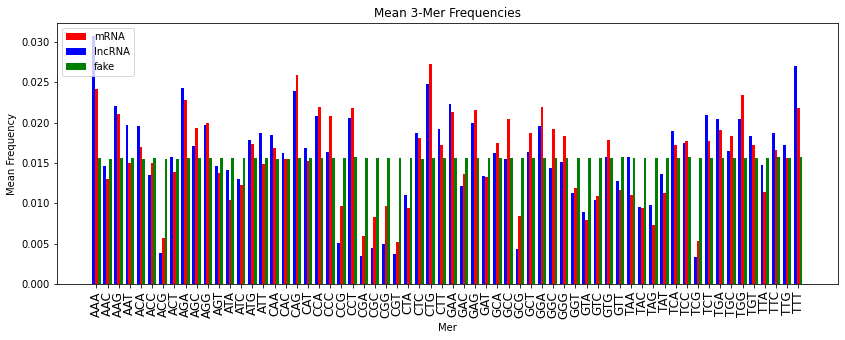

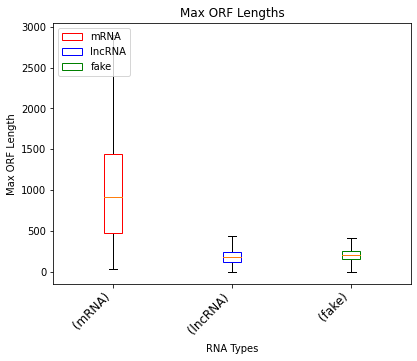

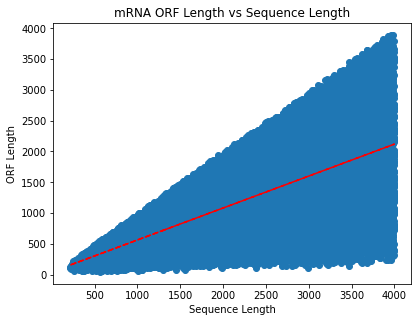

mRNA Sequence Length ORF Length Correlation Coefficient:
	 [[1.         0.71390581]
 [0.71390581 1.        ]]


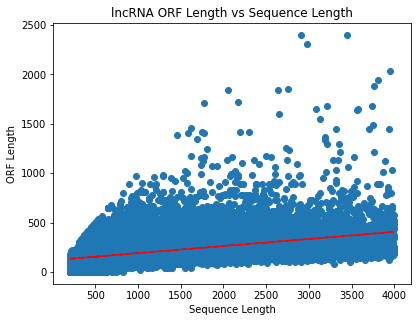

lnc Sequence Length ORF Length Correlation Coefficient:
	 [[1.         0.46743005]
 [0.46743005 1.        ]]


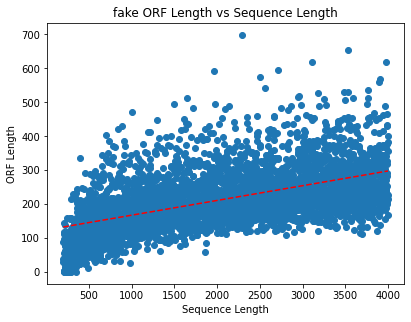

fake Sequence Length ORF Length Correlation Coefficient:
	 [[1.        0.5349612]
 [0.5349612 1.       ]]


In [ ]:
data_set_names = ['mRNA', 'lncRNA', 'fake']

pg = PlotGenerator()
pg.set_text_options(90, 'center', 0, 'center', 12)

pg.set_text('Mean 1-Mer Frequencies', 'Mer', 'Mean Frequency', one_mer_keys, None)
pg.bar_plot([one_mer_pc, one_mer_nc, one_mer_fake], data_set_names)

pg.set_text_options(90, 'center', 0, 'center', 12)
pg.set_text('Mean 2-Mer Frequencies', 'Mer', 'Mean Frequency', two_mer_keys, None)
pg.bar_plot([two_mer_pc, two_mer_nc, two_mer_fake], data_set_names)

pg.set_figure_options(width=14)
pg.set_text_options(90, 'center', 0, 'center', 12)
pg.set_text('Mean 3-Mer Frequencies', 'Mer', 'Mean Frequency', three_mer_keys, None)
pg.bar_plot([three_mer_pc, three_mer_nc, three_mer_fake], data_set_names)

pg.set_figure_options()
pg.set_text_options(45, 'right', 0, 'center', 12)
pg.set_text('Max ORF Lengths', 'RNA Types', 'Max ORF Length', [''], None)
pg.box_plot([pc_max_orf_len, nc_max_orf_len, fake_max_orf_len], data_set_names, False)

pg.set_text('mRNA ORF Length vs Sequence Length', 'Sequence Length', 'ORF Length', None, None)
pg.scatter_plot(pc_seq_len, pc_max_orf_len[0], trendline=True)
print('mRNA Sequence Length ORF Length Correlation Coefficient:')
print('\t', pc_seq_len_orf_len_corrcoef)

pg.set_text('lncRNA ORF Length vs Sequence Length', 'Sequence Length', 'ORF Length', None, None)
pg.scatter_plot(nc_seq_len, nc_max_orf_len[0], trendline=True)
print('lnc Sequence Length ORF Length Correlation Coefficient:')
print('\t', nc_seq_len_orf_len_corrcoef)

pg.set_text('fake ORF Length vs Sequence Length', 'Sequence Length', 'ORF Length', None, None)
pg.scatter_plot(fake_seq_len, fake_max_orf_len[0], trendline=True)
print('fake Sequence Length ORF Length Correlation Coefficient:')
print('\t', fake_seq_len_orf_len_corrcoef)